# Task 6.6
## Sourcing & Analyzing Time Series Data 

In [2]:
#! pip install Quandl

Weather Data Source https://mesonet.agron.iastate.edu/request/download.phtml

In [24]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Load the data 
citibike_data = pd.read_csv("data/citibike_clean.csv")
#quandl.ApiConfig.api_key = "API key"
weather_data = pd.read_csv("data/NYC september Weather.csv")

In [19]:
# Aggregate the weather data by day and hour
weather_agg = weather_data.groupby(['day', 'hour']).agg({
    'temp': 'mean',
    'dewp': 'mean',
    'humid': 'mean',
    'wind_speed': 'mean'
}).reset_index()

# Merge the citibike_data with the aggregated weather data on start_day and start_hour
merged_data = citibike_data.merge(weather_agg, left_on=['start_day', 'start_hour'], right_on=['day', 'hour'], how='left')

merged_selected = merged_data[['Ride_duration_hrs',
       'start_time', 'end_time', 'start_hour', 'end_hour', 'start_day',
       'end_day', 'start_week', 'end_week', 'start_station_name',
       'start_station_latitude', 'start_station_longitude', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'subscriber', 'age',
       'age_group', 'gender', 'gender_label', 'weekday', 'temp',
       'dewp', 'humid', 'wind_speed']]

merged_selected.head()

,Ride_duration_hrs,start_time,end_time,start_hour,end_hour,start_day,end_day,start_week,end_week,start_station_name,...,subscriber,age,age_group,gender,gender_label,weekday,temp,dewp,humid,wind_speed
0,0.275833,2013-09-09 18:18:55,2013-09-09 18:35:28,18,18,9,9,37,37,W 38 St & 8 Ave,...,Subscriber,45.0,40-50,2,Female,Mon,68.36,51.98,55.860000,10.357020
1,0.161389,2013-09-12 18:38:53,2013-09-12 18:48:34,18,18,12,12,37,37,Lispenard St & Broadway,...,Subscriber,30.0,30-40,1,Male,Thu,78.14,70.82,78.536667,11.124207
2,0.100278,2013-09-18 19:44:04,2013-09-18 19:50:05,19,19,18,18,38,38,9 Ave & W 45 St,...,Subscriber,24.0,18-30,1,Male,Wed,62.66,50.66,64.896667,10.357020
3,0.155833,2013-09-28 11:54:37,2013-09-28 12:03:58,11,12,28,28,39,39,E 33 St & 1 Ave,...,Subscriber,25.0,18-30,2,Female,Sat,69.98,50.00,49.126667,9.206240
4,0.118611,2013-09-27 22:01:01,2013-09-27 22:08:08,22,22,27,27,39,39,Lafayette St & E 8 St,...,Subscriber,27.0,18-30,2,Female,Fri,62.30,50.36,65.006667,8.439053


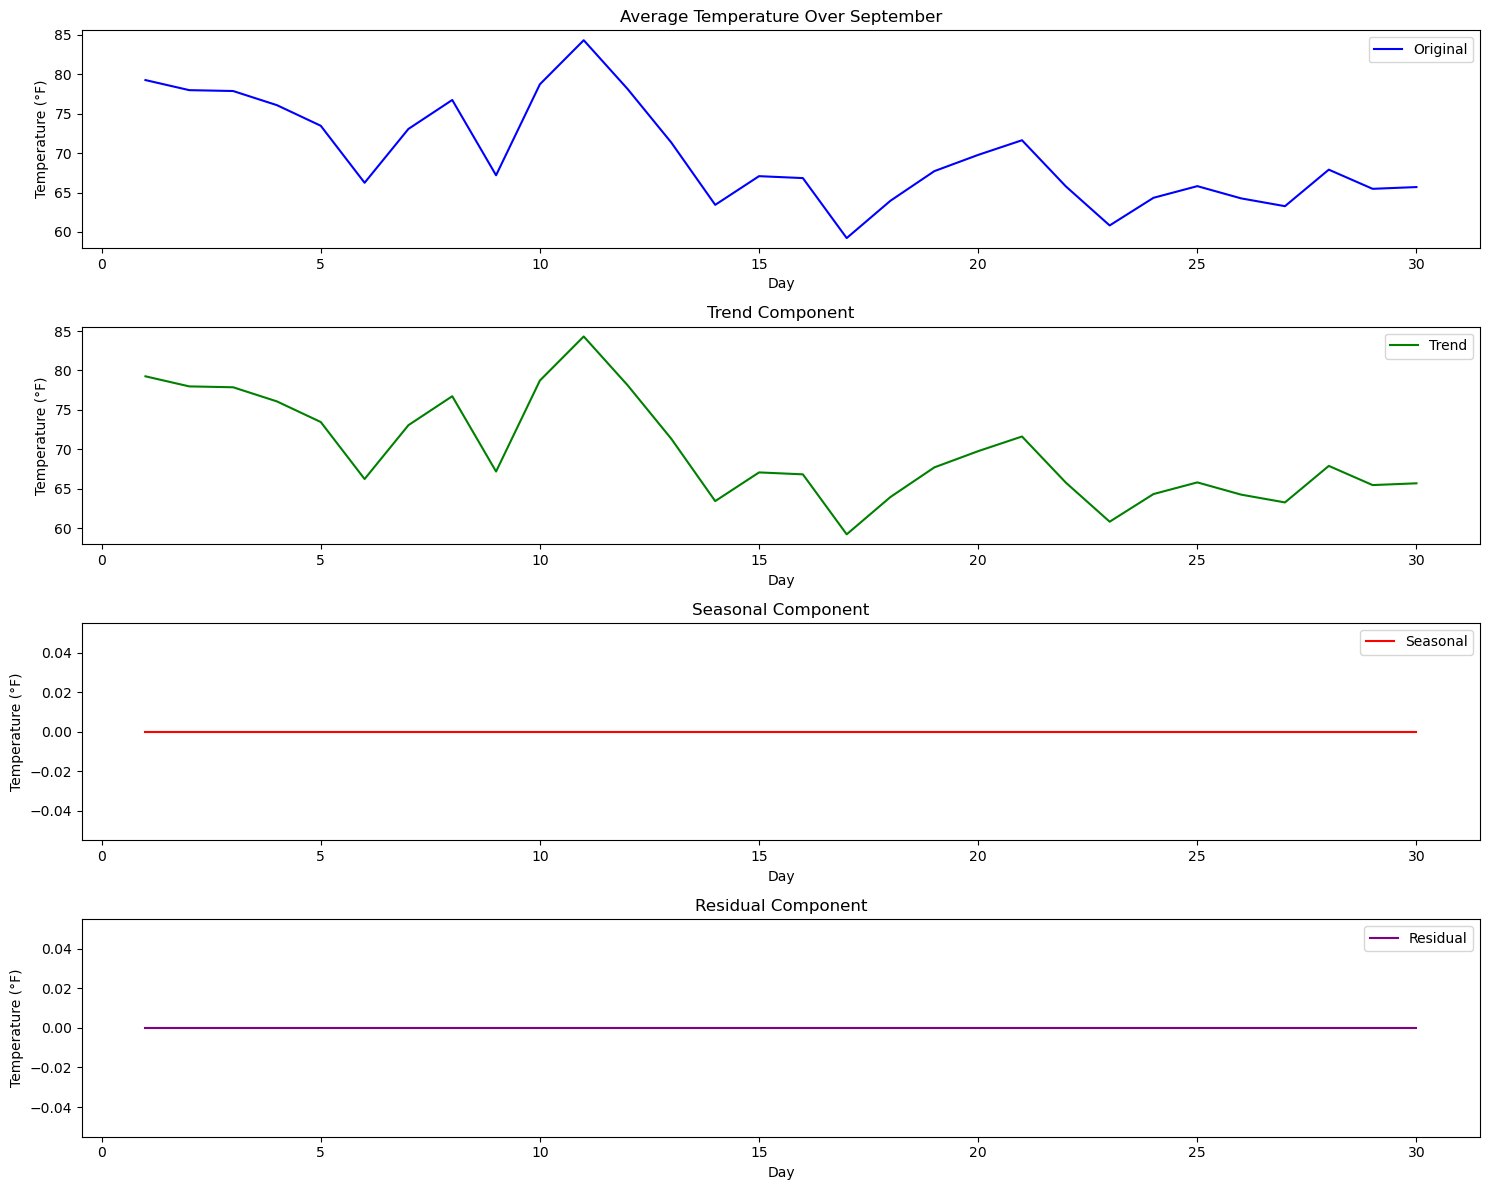

In [23]:
# Group data by day and compute the average temperature for each day
avg_temp_by_day = merged_selected.groupby('start_day')['temp'].mean()

# Decompose the time series using the correct parameter
decomposition = seasonal_decompose(avg_temp_by_day, model='additive', period=1)

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(15, 12))

plt.subplot(4, 1, 1)
plt.plot(avg_temp_by_day, label='Original', color='blue')
plt.legend(loc='best')
plt.title('Average Temperature On September')
plt.xlabel('Day')
plt.ylabel('Temperature (°F)')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='best')
plt.title('Trend Component')
plt.xlabel('Day')
plt.ylabel('Temperature (°F)')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='red')
plt.legend(loc='best')
plt.title('Seasonal Component')
plt.xlabel('Day')
plt.ylabel('Temperature (°F)')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='purple')
plt.legend(loc='best')
plt.title('Residual Component')
plt.xlabel('Day')
plt.ylabel('Temperature (°F)')

plt.tight_layout()
plt.show()


### Temperature Interpretation
The average temperature in September starts relatively high, experiences a dip in the middle, and then rises again towards the end of the month.
The trend indicates a general decline in temperatures, which is expected as we transition from summer to fall.
There's no evident daily seasonality in the temperature data for this month.
The residuals show some variability, suggesting factors other than the overall trend and seasonality influencing daily temperatures.

In [25]:
# Conduct the Dickey-Fuller test on the average temperature data
result = adfuller(avg_temp_by_day)

# Extract and display the test statistic and p-value
test_statistic, p_value = result[0], result[1]
test_statistic, p_value

(-1.1312791670960776, 0.7024383509003311)

#### Dickey-Fuller Test Results:
- Test Statistic: -1.1313
- p-value: 0.7024

**Given the p-value of 0.7024 (which is greater than the common significance level of 0.05), we fail to reject the null hypothesis. This suggests that the average temperature data is non-stationary.**

In [26]:
# Perform first differencing on the data
first_difference = avg_temp_by_day.diff().dropna()

# Conduct the Dickey-Fuller test on the differenced data
result_first_diff = adfuller(first_difference)

# If the p-value from the first differencing is still above 0.05, perform a second differencing and repeat the test
if result_first_diff[1] > 0.05:
    second_difference = first_difference.diff().dropna()
    result_second_diff = adfuller(second_difference)
else:
    result_second_diff = None

result_first_diff[1], result_second_diff[1] if result_second_diff else None


(0.03480027151129571, None)

### Autocorrection Check 
After the first round of differencing, the p-value is 0.0348, which is less than the common significance level of 0.05. This suggests that the differenced data is now stationary.